# Исследование данных по расположению санитарной авиации в России

### Используемые библиотеки

In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gmaps as jupgmaps
from datetime import datetime
import matplotlib
%matplotlib inline
import json
import requests
from osmapi import OsmApi
import geopy
from geopy.distance import vincenty
import math
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import googlemaps as gmaps
import gmaps.geojson_geometries
import transliterate
import geojson_utils
pd.options.display.max_rows = 100

In [153]:
api_key = os.environ["GOOGLE_API_KEY"]
gmaps = googlemaps.Client(key=api_key)
jupgmaps.configure(api_key=api_key)

In [154]:
def get_coord(points): # на вход массив строковых названий
    data_json = []
    for adr in tqdm(list(points)):
        data_json += [gmaps.geocode('Россия, ' + adr)]
    data_coord = []
    for i, js in enumerate(data_json):
        if js:
            try:
                coord = js[0]['geometry']['location']
                data_coord += [(coord['lat'], coord['lng'])]
            except Exception as e:
                data_coord += [(None, None)]
        else:
            data_coord += [(None, None)]
    return data_coord

In [137]:
with open('data/regions_russia1.geojson', 'r') as f:
    georussia = json.load(f)
def get_region(point):
    if isinstance(point, pd.Series):
        lat = point['lat']
        lon = point['lon']
    elif isinstance(point, tuple) or isinstance(point, list):
        lat = point[0]
        lon = point[1]
    p = {"type": "Point", "coordinates": [lon, lat]}
    for region in georussia['features']:
        if geojson_utils.point_in_multipolygon(p, region['geometry']):
            return region['gibdd_code']
    return None

### Расчет плотности по областям
возможно уже не надо

In [418]:
dens = pd.read_csv('data/plotn1.csv', encoding='utf-8', sep=';', header=None)
del dens[0]
dens.columns = ['obl', 'dens', 'people', 'S', 'FO', 'city']

In [420]:
dens = dens.reset_index()
del dens['index']

In [426]:
pd.options.display.max_rows = 100

In [204]:
oblast_coord = get_coord(dens)

100%|██████████| 85/85 [00:08<00:00, 10.38it/s]


In [181]:
df = pd.DataFrame(oblast_coord)
df['dens'] = dens.dens
df['obl'] = dens.obl
df.dens = df.dens.apply(lambda x: float(x.replace(',','.')))

In [289]:
scaler = MinMaxScaler()

In [ ]:
data.dens = scaler.fit_transform(data.dens)

### Загрузка и подготовка данных о больницах

In [ ]:
# первоначальное
hospitals = pd.read_excel('data/hosp_data_bin.xlsx')
hosp_coord = get_coord(hospitals['Адрес'])
hosp_coord_df = pd.DataFrame(hosp_coord, columns=['lat', 'lon'])
hospitals = hospitals.join(hosp_coord_df).dropna()
hospitals.to_excel('data/hospitals_with_coord.xlsx')

In [288]:
hospitals = pd.read_excel('data/hospitals_with_coord.xlsx')

In [300]:
hospitals = hospitals[hospitals[['Челюстно-лицевая хирургия', 'Гемодиализ', 'Колопроктология',
       'Ортопедия', 'Оториноларингология', 'Кардиохирургия', 'Детская эндокринология', 'Анастезиология и реаниматология', 'Диабетология', 'Пульмонология', 'Иммунология', 'Иммунопрофилактика',
       'Сосудистая хирургия', 'Неврология', 'Хирургия гнойная', 'Стоматология хирургическая', 'Дерматология', 'Офтальмология', 'Гериатрия', 'Аллергология и иммунология', 'Стоматология', 'Урология',
       'Травматология', 'Стоматология детская', 'Стоматология терапевтическая', 'Токсикология', 'ЭНДОКРИНОЛОГИЯ (ТЕРАПЕВТИЧЕСКАЯ)', 'Общая врачебная практика (семейная медицина)',
       'Акушерство и гинекология', 'Рентгенология', 'ТЕРАПИЯ (ОБЩАЯ)', 'Радиология', 'Психиатрия', 'Ревматология', 'Ортодонтия', 'Торакальная хирургия', 'Абдоминальная хирургия', 'Химиотерапия',
       'Неонатология', 'Кардиология', 'Педиатрия', 'Гастроэнтерология', 'Хирургия', 'Гематология', 'Инфекционные болезни', 'Восстановительная медицина', 'Лечебное дело', 'Детская кардиология',
       'Детская онкология', 'Онкология', 'Физиотерапия', 'Детская хирургия', 'Общая практика', 'Акушерство', 'Детская урология-андрология', 'Нейрохирургия', 'Другое', 'Хирургия (комбустиология)',
                     'Нефрология']].sum(axis=1)>0]

In [303]:
hospitals = hospitals.reset_index()
del hospitals['index']

In [ ]:
hospitals['id_google'] = -1
# hospitals['']
for i, coord1 in enumerate(hospitals[['lat', 'lon']].values):
#     lat, lon = coord[0], coord[1]
    for j, coord2 in enumerate(hosp_google[['lat', 'lon']].values):
        if vincenty(tuple(coord1), tuple(coord2)).km <= 2.0:
            hospitals.set_value(i,'id_google', j)
#             hospitals.set_value(i,'id_google', j)
            break

In [ ]:
hosp_google = hosp_google.reset_index()
hospitals_merged = hospitals[hospitals['id_google']>=0][['Наименование организации', 
                                      'Субъект РФ', 'Адрес', 'id_google']].merge(hosp_google, how='left',
                                                                                 left_on='id_google', right_on='index')

In [203]:
hosp_google = pd.read_csv('data/hosp_correct.csv')
del hosp_google['Unnamed: 0']

In [305]:
m = jupgmaps.Map()
symbols = jupgmaps.symbol_layer(
    hosp_google[['lat', 'lon']], fill_color="red", stroke_color="red")
m.add_layer(symbols)

### Данные по городам

In [37]:
cities_coord = pd.read_csv('data/lat_lon_cities.csv', sep=';', encoding='cp1251')
del cities_coord['Unnamed: 0']
cities_coord.columns = [  u'District',u'Region',u'Subdistrict',u'City', u'Latitude', u'Longitude',
           u'Актуален М',     u'Актуален В',     u'Актуален Е',
          u'Unnamed: 10',    u'Unnamed: 11']

In [45]:
regions_good = pd.read_excel('data/regions_good.xls')

In [40]:
reg_gb = regions_good.groupby('index_name')

In [52]:
gr1 = list(reg_gb.groups.keys())[0]

In [55]:
df = reg_gb.get_group(gr1)

In [57]:
df.head(2)

,city_name,regn_name,long,lat,index_name,measure,ID,index,type,2003,2004,2005,2006,2007,2008,2009,2010,2011
6,Благовещенка,Алтайский край,52.781111,79.520000,Инвестиции в основной капитал за счет бюджетны...,тыс. руб.,69,11,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,Степное Озеро,Алтайский край,52.465200,79.849444,Инвестиции в основной капитал за счет бюджетны...,тыс. руб.,70,11,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
df= df[['city_name', 'regn_name', '2011']]

In [67]:
df = df.dropna()

### Данные по агломерациям

In [10]:
aglom = pd.read_excel('data/airports_agglo.xlsx', sheetname='Aglom')

In [11]:
aglom.columns

Index(['city rus', 'reg', 'lat', 'long', 'Unnamed: 4', 'Unnamed: 5',
       'pop 2010', ' code by range 3', 'airp', 'dist', 'numb', 'Unnamed: 11',
       'Unnamed: 12', 'city rus.1', 'reg.1', 'Unnamed: 15', 'city rus.2',
       'region', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20'],
      dtype='object')

In [12]:
aglom_df = aglom[['city rus', 'reg', 'lat', 'long', "pop 2010", 'airp', 'dist']].copy()

In [13]:
aglom_df['class'] = 0

In [14]:
aglom_df.columns = ['city', 'region', 'lat', 'long', "pop", 'airp', 'dist', 'class']

* 0 класс: 1 - 999 чел / 258
* 1 класс: 1000 - 9999 чел / 653
* 2 класс: 10000 - 49999 чел / 639
* 3 класс: 50000 - 149999 чел / 199
* 4 класс: > 150000 чел / 107
* 5 класс: > 1млн / 12

In [15]:
aglom_df = aglom_df.reset_index()
del aglom_df['index']

In [164]:
def popul(x):
    if x['pop'] < 1000:
        x['class'] = 0
    elif x['pop'] < 10000:
        x['class'] = 1
    elif x['pop'] < 50000:
        x['class'] = 2
    elif x['pop'] < 150000:
        x['class'] = 3
    elif x['pop'] < 1000000:
        x['class'] = 4
    else:
        x['class'] = 5
    return x

In [17]:
aglom_df = aglom_df.apply(lambda x: popul(x), axis=1)

Квантиль 75% отсечение далеких от аэропорта пунктов

In [18]:
scaler = MinMaxScaler()
aglom_df['class'] = scaler.fit_transform(aglom_df['class'].reshape(-1, 1))

/home/ubuntu/.local/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  from ipykernel import kernelapp as app
/home/ubuntu/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


In [19]:
aglom_df['class'].value_counts().sort_index()

0.0    258
0.2    653
0.4    639
0.6    199
0.8    107
1.0     12
Name: class, dtype: int64

### Данные по аэродромам

In [5]:
droms = pd.read_csv('data/aopa-points-export.csv', sep=';')

In [6]:
droms = droms[(droms["Страна"] == 'Россия') & (droms["Действующий"] == 'Действующий')]

In [27]:
droms_city = droms[droms['Город'].notnull()]

In [6]:
droms.columns

Index(['Действующий', 'Тип', 'Название', 'Город', 'Индекс', 'Индекс RU',
       'Код страны', 'Страна', 'КТА', 'Превышение', 'Принадлежность',
       'Международный', 'Email', 'Web-сайт', 'Примечание'],
      dtype='object')

In [8]:
droms['Принадлежность'].unique()

array(['ГА', 'АОН', 'МО', 'МЧС', 'МВД', 'ФСБ', 'ЭА', 'ДОСААФ', nan], dtype=object)

In [7]:
droms['lon'] = None
droms['lat'] = None

In [8]:
def lonlat(x):
    lat, lon = x['КТА'].split()
    lon = lon[1:-1]
    lat = lat[1:-1]
    x['lon'] = float(lon)
    x['lat'] = float(lat)
    return x

In [9]:
droms = droms.apply(lambda x: lonlat(x), axis=1)

In [10]:
aero_types = ['ГА', 'АОН', 'МЧС']

In [13]:
droms_grazhd = droms[droms['Принадлежность'].isin(aero_types)]

In [15]:
droms_grazhd.to_csv('droms_grazhd.csv', index=None)

In [16]:
droms[droms['Принадлежность'] == 'ДОСААФ'].to_csv('droms_dosaaf.csv', index=None)

In [17]:
droms.to_csv('droms_all.csv', index=None)

In [79]:
droms = droms[droms['Тип'] == 'Аэродром']

### Вывод общей карты

In [193]:
m = jupgmaps.Map()
cyan = (0,255,255, 0.8)
heatmap_layer = jupgmaps.heatmap_layer(aglom_df[['lat','long']], weights=aglom_df['class'], point_radius=15)#, max_intensity=np.mean(df.iloc[:10].dens))

hosp = jupgmaps.symbol_layer(
    hosp_g[['lat', 'lon']], fill_color='red', stroke_color='red', scale=2)

# aero = jupgmaps.symbol_layer(
#     droms[['lat', 'lon']], fill_color="purple", stroke_color="purple", scale=2)

# m.add_layer(aero)
m.add_layer(hosp)
m.add_layer(heatmap_layer)

In [5]:
russia_js = json.load(open('data/russia.geojson.js', 'r'))

In [85]:
with open("data/regions_russia1.geojson") as f:
    geometry = json.load(f)

In [86]:
m = jupgmaps.Map()
geojson_layer = jupgmaps.geojson_layer(geometry)
m.add_layer(geojson_layer)

In [82]:
del geometry['features'][2]

In [485]:
for i, g in enumerate(geometry['features']):
    print(i, g['name'])

0 Уральский федеральный округ
1 Северо-Западный федеральный округ
2 Приволжский федеральный округ
3 Южный федеральный округ
4 Северо-Кавказский федеральный округ
5 Центральный федеральный округ
6 Дальневосточный федеральный округ
7 Сибирский федеральный округ


### Поиск дополнительных данных по больницам по Google Places API

In [132]:
aglom_coords = [tuple(x) for x in aglom_df[['lat', 'long']].values]

In [179]:
hospitals_google = []
cnt = 0
for coord in aglom_coords:
    if coord[1] >= 68.7:
        res = gmaps.places('районная больница', coord, radius=50000)
    #     print(1)
        try:
            i = 0
            for data in res['results']:
                if 'Russia' in data['formatted_address']:
                    hosp_data = (
                        data['geometry']['location']['lng'],
                        data['geometry']['location']['lat'],
                        data['formatted_address'],
                        data['name']
                    )
                    hospitals_google += [hosp_data]
                    i += 1
                if i == 4:
                    break
            cnt+=1
            if cnt % 100 == 0:
                print(cnt)
        except:
            continue

100
200
300
400
500
600


### Данные по заболеваемости

In [36]:
illness = pd.read_excel('data/Заболеваемость.xlsx')
ill_reg  = list(illness['Регион'])
illness.columns = ['region', '2010', '2011', 'mean', 'mean_man']
illness = illness.set_index('region')
illness = illness['mean_man']

In [38]:
okr_idx = illness.index[illness.index.str.contains('федеральный округ')]
okr_ill = illness.index.isin(okr_idx)

In [39]:
illness[~(okr_ill)][1:].to_csv('regions_illness.csv')

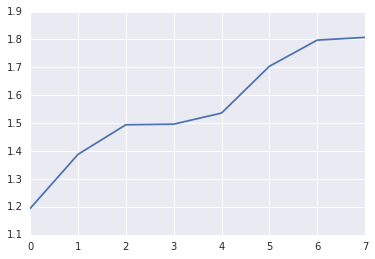

In [40]:
plt.plot(list(illness[okr_idx].sort_values()))

In [112]:
illness[okr_idx]

region
Центральный федеральный округ          1.494413
Северо-Западный федеральный округ      1.797771
Южный федеральный округ                1.388362
Северо-Кавказский федеральный округ    1.194677
Приволжский федеральный округ          1.807590
Уральский федеральный округ            1.496550
Сибирский федеральный округ            1.703897
Дальневосточный федеральный округ      1.536326
Name: mean_man, dtype: float64

In [89]:
okruga = pd.read_excel('data/okruga.xlsx')
okruga['people'] = okruga['people'].apply(lambda x: int(x.replace('\xa0','')))
okruga['S'] = okruga['S'].apply(lambda x: int(x.replace('\xa0','')))
okruga['dens'] = okruga['people'] / okruga['S']

In [90]:
okruga

,name,S,people,count_sub,center,prirost,VRP,dens
0,Центральный федеральный округ,650205,39209582,18,Москва,"-1,8",22 714,60.303415
1,Северо-Западный федеральный округ,1686972,13899310,11,Санкт-Петербург,"-1,2",6790,8.239206
2,Южный федеральный округ[8],447821,16428458,8,Ростов-на-Дону,"-1,3",4591,36.685323
3,Северо-Кавказский федеральный округ,170439,9775770,7,Пятигорск,"8,1",1704,57.356415
4,Приволжский федеральный округ,1036975,29636574,14,Нижний Новгород,"-0,3",9916,28.579835
5,Уральский федеральный округ,1818497,12345803,6,Екатеринбург,"1,9",8980,6.789015
6,Сибирский федеральный округ,5144953,19326196,12,Новосибирск,"0,8",6752,3.756341
7,Дальневосточный федеральный округ,6169329,6182679,9,Хабаровск,"0,9",3719,1.002164


In [451]:
okruga.sort_values(by='dens')

,name,S,people,count_sub,center,prirost,VRP,dens
7,Дальневосточный федеральный округ,6169329,6182679,9,Хабаровск,"0,9",3719,1.002164
6,Сибирский федеральный округ,5144953,19326196,12,Новосибирск,"0,8",6752,3.756341
5,Уральский федеральный округ,1818497,12345803,6,Екатеринбург,"1,9",8980,6.789015
1,Северо-Западный федеральный округ,1686972,13899310,11,Санкт-Петербург,"-1,2",6790,8.239206
4,Приволжский федеральный округ,1036975,29636574,14,Нижний Новгород,"-0,3",9916,28.579835
2,Южный федеральный округ[8],447821,16428458,8,Ростов-на-Дону,"-1,3",4591,36.685323
3,Северо-Кавказский федеральный округ,170439,9775770,7,Пятигорск,"8,1",1704,57.356415
0,Центральный федеральный округ,650205,39209582,18,Москва,"-1,8",22 714,60.303415


### Расчет корреляций по регионам

In [20]:
inp = pd.read_excel('data/inp_ran.xlsx')

In [23]:
count = 0
i = -1
regions = []
dfs = [pd.DataFrame([], columns=inp.columns)] * 81
for index, row in inp.iterrows():
    index = str(index)
    if not index.isdigit():
        if index == 'nan':
            start = True
            continue
        count += 1
        if 'федеральный округ' in index:
            continue
        i += 1
#         print(i, index)
        regions += [index]
    else:
        if int(index) < 2013:
            dfs[i] = dfs[i].append(row)#, ignore_index=True)
#     if i == 2:
#         break

In [24]:
regions[0] = 'Российская Федерация'
regions[18] = 'гор. Москва'
regions[28] = 'гор. Санкт - Петербург'
regions[38] = "Карачаево-Черкесская Респ."
regions[37] = 'Кабардино-Балкарская Респ.'
regions[39] = 'Р. Северная Осетия - Алания'
regions[79] = 'Еврейская авт.область'

In [25]:
for i, df_inp in enumerate(dfs):
    dfs[i] = dfs[i].transpose()
    dfs[i]['region'] = regions[i]

In [26]:
df_inp = pd.concat(dfs)

In [27]:
df_inp = df_inp.reset_index()

In [29]:
inp_gb = df_inp.groupby('index')

In [30]:
features_df = pd.DataFrame(index = gr1.index)

NameError: name 'gr1' is not defined

In [34]:
for i in range(len(inp_gb.groups.keys())):
    name = list(inp_gb.groups.keys())[i]
    gr1 = inp_gb.get_group(name)
    gr1 = gr1.set_index('region')
    del gr1['index']
    gr1['mean'] = gr1.mean(axis=1)
    gr1['diff'] = gr1[2012] - gr1[2009]
    features_df[name] = gr1['mean']

In [41]:
features_df['ILLNESS'] = illness

In [167]:
features_df.to_csv('features_data.csv')

In [32]:
features_df = pd.read_csv('features_data.csv')
features_df = features_df.set_index('region')

Ниже - данные по вызовам скорой и т п

In [87]:
carpet_new = pd.read_excel('data/carpet.xlsx')

In [88]:
carpet_new = carpet_new[~(carpet_new['Субъекты Российской Федерации'].str.contains('федеральный округ'))]

In [97]:
carpet_new = carpet_new[~(carpet_new['Субъекты Российской Федерации'].isin(
                           ['Ненецкий автономный округ'
                            'Ханты-Мансийский авт.округ'
                            'Ямало-Ненецкий авт.округ']))]

In [65]:
for sub in list(carpet_new['Субъекты Российской Федерации']):
    if not (sub in list(features_df.index)):
        print(sub)

Ненецкий автономный округ
Ханты-Мансийский авт.округ
Ямало-Ненецкий авт.округ


In [ ]:
carpet_new

In [80]:
carpet_new.columns = [transliterate.translit(col, language_code='ru', reversed=True) for col in carpet_new.columns]
# features_df.columns

In [107]:
features_df.columns = [transliterate.translit(col, language_code='ru', reversed=True) for col in features_df.columns]
# features_df.columns

In [69]:
scaler = MinMaxScaler()

In [41]:
features_df.ILLNESS = scaler.fit_transform(features_df.ILLNESS)

/home/ubuntu/.local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/ubuntu/.local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [96]:
features_df = features_df.reset_index()

In [102]:
features_df = features_df.merge(carpet_new, how='inner', left_on='region', right_on='Субъекты Российской Федерации')

In [106]:
features_df.corr().to_excel('correlations_all.xlsx')

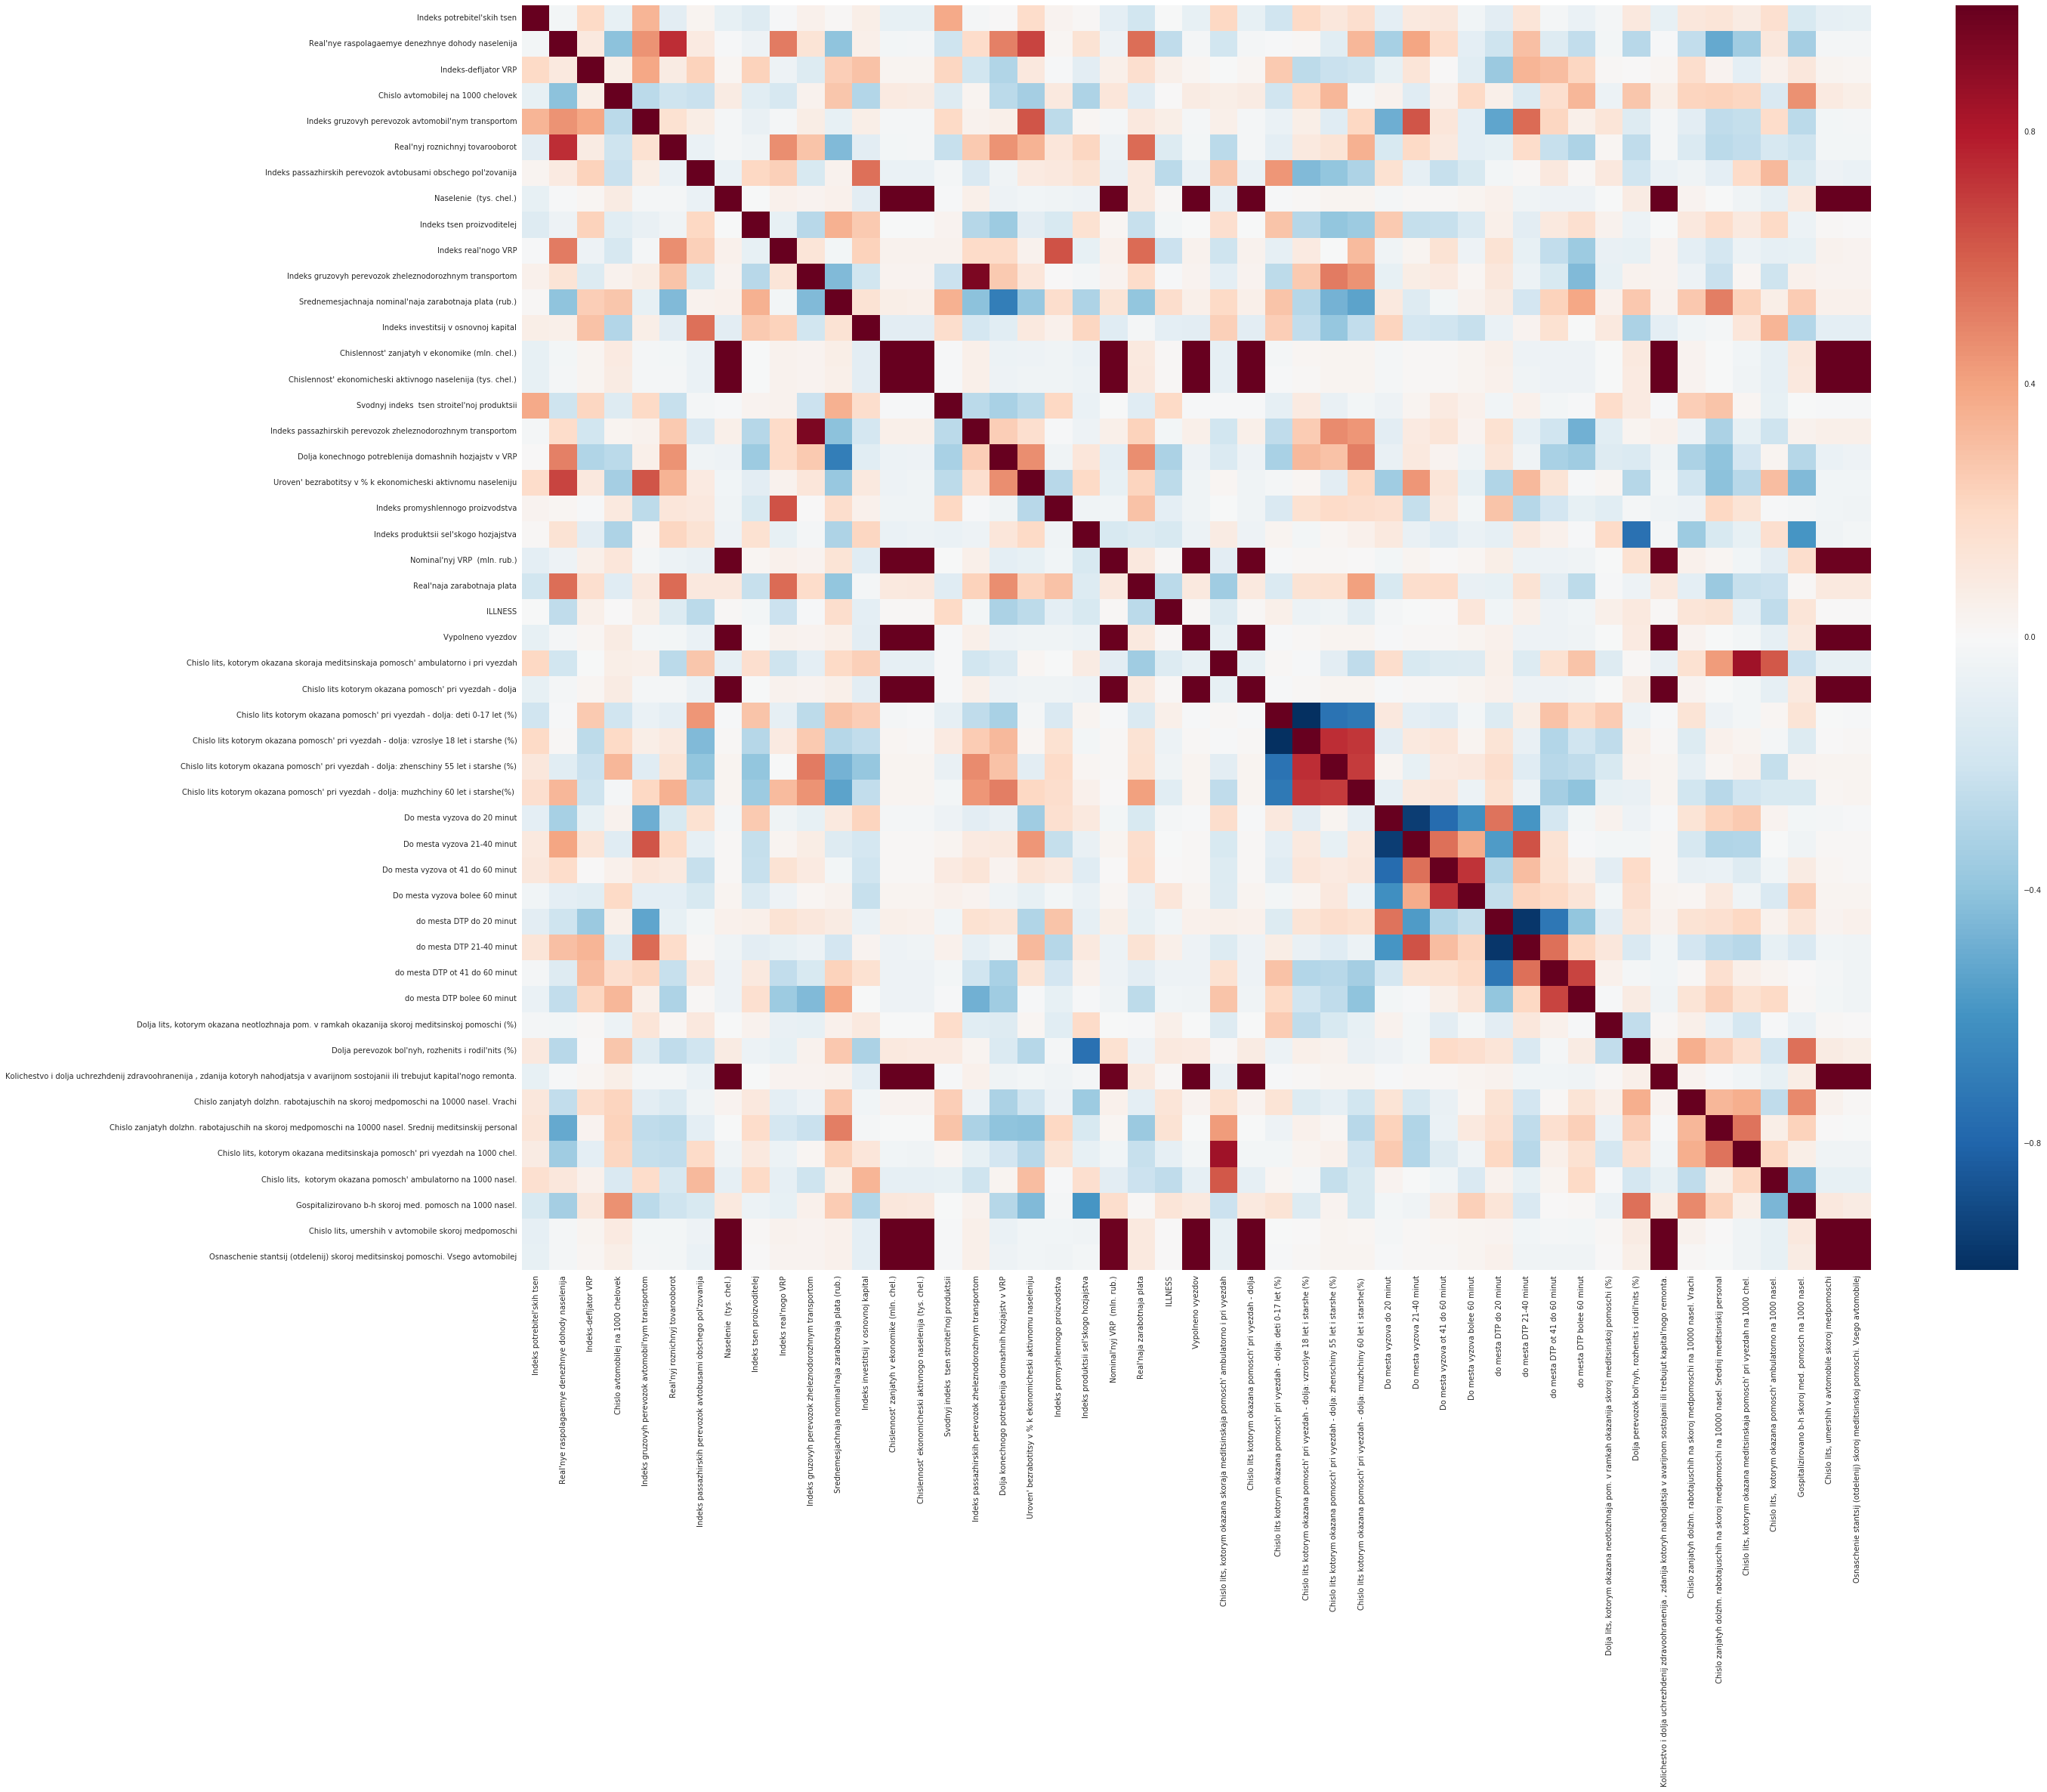

In [110]:
matplotlib.rc('font',**{'family':'Verdana', 'size':50})
plt.figure(figsize=(40,30))
fg = sns.heatmap(features_df.corr(),rasterized=True)

In [111]:
fg.get_figure().savefig("kover.png")

## Расчеты

#### агломерации около точки

In [235]:
aglom_coords = [tuple(x) for x in aglom[['lat', 'long']].values]
def get_agloms(point, r):
    # point: tuple (lon, lat)
    points = [x for x in aglom_coords if (vincenty(point, x).km <= r)]
    return points

In [238]:
%%timeit
get_agloms((55.750063, 37.322022), 20.)

10 loops, best of 3: 53.7 ms per loop


In [240]:
hosp_coords = [tuple(x) for x in hosp_g[['lat', 'lon']].values]
def get_hospitals(point, r):
    # point: tuple (lon, lat)
    points = [x for x in hosp_coords if (vincenty(point, x).km <= r)]
    return points

#### Матрица расстояний больниц от аэродромов

In [260]:
dist_matrix = np.zeros((len(droms), len(droms)))

In [256]:
droms_coords = [tuple(x) for x in droms[['lat', 'lon']].values]

In [266]:
for i in range(len(droms)):
    for j in range(len(droms)):
        dist_matrix[i, j] = vincenty(droms_coords[i], droms_coords[j]).km

#### Расчеты зон покрытия вертолетом

In [220]:
def toRadians(angleInDegrees):
    return angleInDegrees * math.pi / 180.


def toDegrees(angleInRadians):
    
    return angleInRadians * 180. / math.pi


def offset(c1, distance, bearing):
    lat1 = toRadians(c1[1])
    lon1 = toRadians(c1[0])
    dByR = distance / 6378137 # distance divided by 6378137 (radius of the earth) wgs84
    lat = math.asin(
    math.sin(lat1) * math.cos(dByR) +
    math.cos(lat1) * math.sin(dByR) * math.cos(bearing))
    lon = lon1 + math.atan2(
        math.sin(bearing) * math.sin(dByR) * math.cos(lat1),
        math.cos(dByR) - math.sin(lat1) * math.sin(lat))
    return [toDegrees(lon), toDegrees(lat)]

def circleToPolygon(center, radius, numberOfSegments=None):
    
    n = numberOfSegments if numberOfSegments else 32
    flatCoordinates = [offset(center, radius, 2 * math.pi * i / n) for i in range(n)]
#     for (let i = 0; i < n; ++i) {
#         flatCoordinates.push.apply(flatCoordinates, offset(center, radius, 2 * Math.PI * i / n));
#     }
#     print(flatCoordinates)
    flatCoordinates += [flatCoordinates[0]]
    coordinates = []
   
    for j in range(0,len(flatCoordinates),2):
        coordinates += flatCoordinates[j:j+2]

    return {
      'type': 'Polygon',
      'coordinates': [list(reversed(coordinates))]
    }

In [219]:
def get_circle(geom, region):
    circle = { "type": "Feature",
             "geometry": geom,
             "properties": {
               "region": region
               },
             }
    return circle
def add_circles(coords, radius=200): # km
    circles = { "type": "FeatureCollection",
    "features": []
     }
    if not (isinstance(radius, list)):
        radius = [radius]*len(coords)
    for i, coord in enumerate(coords):
        circles['features'] += [get_circle(circleToPolygon((coord[1], coord[0]), radius[i]*1000), get_region(coord))]
    return circles

In [307]:
test = add_circles([(55.748049, 37.624572), (55.704739, 38.377261)])

#### Попадание точек в зону покрытия вертолета

In [23]:
def get_square(dist, mylon, mylat):
    lon1 = mylon-dist/abs(math.cos(math.radians(mylat))*111.0) # 1 градус широты = 111 км
    lon2 = mylon+dist/abs(math.cos(math.radians(mylat))*111.0)
    lat1 = mylat-(dist/111.0)
    lat2 = mylat+(dist/111.0)
    square = (
        lon1,
        lon2,
        lat1,
        lat2
    )
    return square

In [24]:
def dot_in_square(lon, lat, square):
    lon1,lon2,lat1,lat2 = square
    if lon > lon1 and lon < lon2 and lat > lat1 and lat < lat2:
        return True

#### Загрузка центров

In [138]:
centers = pd.read_csv('data/citys.csv', header=None)
centers = list(centers[0])

In [214]:
centers_persp = pd.read_excel('data/citys_200400.xlsx', sheetname='Перспективный парк МВЛ', header=None)

In [228]:
centers_existing = pd.read_excel('data/citys_200400.xlsx', sheetname='Существующий парк МВЛ', header=None)

In [221]:
centers = list(centers_persp[0])
radius = list(centers_persp[1])

In [229]:
centers = list(centers_existing[0])
radius = list(centers_existing[1])

In [230]:
center_coords = get_coord(centers)

100%|██████████| 13/13 [00:01<00:00, 10.94it/s]


In [222]:
circles_perspective_various = add_circles(center_coords, radius)

In [226]:
circles_perspective_400 = add_circles(center_coords, 400)

In [231]:
circles_existing_various = add_circles(center_coords, radius)

In [232]:
circles_existing_400 = add_circles(center_coords, 400)

In [234]:
with open(out_dir + '/circles_existing_400.geojson', 'w') as jfile:
    json.dump(circles_existing_400, jfile)

In [157]:
test = add_circles(center_coords, 150)

In [158]:
test1 = add_circles(center_coords, 400)

In [238]:
m1 = jupgmaps.Map()
# hosp = jupgmaps.symbol_layer(
#     hospitals[['lat', 'lon']], fill_color='red', stroke_color='red', scale=2)
circle_layer = jupgmaps.geojson_layer(circles_perspective_various)
# aero = jupgmaps.symbol_layer(
#     droms[['lat', 'lon']], fill_color="blue", stroke_color="blue", scale=2)

# m1.add_layer(aero)
# heatmap_layer = jupgmaps.heatmap_layer(aglom_df[['lat','long']], weights=aglom_df['class'], point_radius=15) #, max_intensity=np.mean(df.iloc[:10].dens))
# m1.add_layer(hosp)
m1.add_layer(circle_layer)
# m1.add_layer(heatmap_layer)

### Расчет покрытия

In [75]:
pd.options.display.max_columns = 25
pd.options.display.max_columns = 300

In [122]:
aglom_df = aglom_df.reset_index()
del aglom_df['index']

In [123]:
aglom_coords = [tuple(x) for x in aglom_df[['lat', 'long']].values]

In [63]:
coverage

[8326018.0, 23521137.0, 7427609.0, 715600.0, 656765.0]

In [141]:
agloms_ids = list(set(agloms_covered))

In [88]:
aglom_df.iloc[agloms_ids]['pop'].sum() / aglom_df['pop'].sum()

0.00037820842759853643

In [89]:
aglom_df.iloc[agloms_ids]['pop'].sum() / 142100000

0.00026902885292047853

In [150]:
len(hospitals)

1208

In [115]:
centers_list = ['Москва', 'Брянск', 'Санкт-Петербург', 'Сыктывкар', 'Волгоград', 'Краснодар', 'Нижний Новгород', 'Оренбург', 'Пермь', 'Саратов', 'Салехард', 'Тюмень', 'Хатанга', 'Красноярск', 'Горно-Алтайск', 'Кызыл', 'Хабаровск', 'Петропавловск-Камчатский']

In [243]:
# name = 'data/citys.csv'
# centers = pd.read_csv('data/citys.csv', header=None)
aglom_coords = [tuple(x) for x in aglom_df[['lat', 'long']].values]
# centers_list = list(centers[0])
center_coords = get_coord(centers_list)
r = 400
agloms_covered = []
coverage = []
agloms_counted = set()
for point in center_coords:
    agloms_covered = [i for i,x in enumerate(aglom_coords) if (vincenty(point, x).km <= r) and not(i in agloms_counted)]
    agloms_counted |= set(agloms_covered)
    coverage += [aglom_df.iloc[agloms_covered]['pop'].sum()]
# centers['coverage'] = coverage

100%|██████████| 46/46 [00:04<00:00,  9.30it/s]


In [244]:
pd.DataFrame({'center':centers_list, 'coverage':coverage}).coverage.sum() #/ aglom_df['pop'].sum()

96716481.0

по названию субъекта сколько больниц и сколько аэродромов

In [139]:
aglom_df.groupby('region').size().to_csv('aglom_region_count.csv', encoding='utf-8')

In [149]:
for i, elem in enumerate(hospitals.adr):
    print(elem)
    if i>10:a
        break

ул.Центральная, 1, лит.Л, рп Краснообск, дом, Novosibirsk Oblast, Russia, 630501
Botanicheskaya ul., 2 А, Minusinsk, Krasnoyarsk Krai, Russia, 662606
ul. Pushkina, 1, Belyy Yar, Republic of Khakassia, Russia
Юности ул., 1-а, с. Краснотуранское, Krasnoyarsk Krai, Russia, 662660
Советская ул., 14, Idrinskoye, Krasnoyarsk Krai, Russia, 662680
pr. Shakhterov, 113, Kemerovo, Kemerovo Oblast, Russia, 650002
ул. Революционеров, д. 7, Belebey, Republic of Bashkortostan, Russia, 452000
Школьная ул., 29, пос. Ермекеево, Republic of Bashkortostan, Russia, 452190
ul. Pushkina, 17a, Bizhbulyak, Russia
Центральная ул., 6, Похвистневский р-н, Старомансуркино с., Samara Oblast, Russia, 446475
Sovetskaya ul., 39, Kumertau, Republic of Bashkortostan, Russia, 453300
Svetlaya ul., 12, Kinel', Samara Oblast, Russia, 446436


#### Аэродромы около больниц

In [ ]:
agloms_covered = [i for i,x in enumerate(aglom_coords) if ((vincenty(point, x).km <= r) and not(i in agloms_counted))]

In [124]:
droms_coords = [tuple(x) for x in droms[droms['Принадлежность'].isin(aero_types)][['lat', 'lon']].values]

In [290]:
hospitals = hosp_google

In [293]:
hospitals['drom_count'] = 0

In [294]:
r = 5
def func(row):
    return len([i for i,x in enumerate(droms_coords) if (vincenty((row['lat'],row['lon']), x).km <= r)])
hospitals['drom_count_5km'] = hospitals.apply(func, axis=1)

In [126]:
hospitals[hospitals['drom_count_5km']>0].to_excel('hosp_aero_5km.xlsx', index=None)

In [127]:
hospitals[hospitals['drom_count_5km']>4].count()

lon               2
lat               2
adr               2
name              2
drom_count_5km    2
dtype: int64

In [249]:
to_count = pd.read_excel('data/aglom.xlsx', header=None)
del to_count[1]

In [250]:
to_count.columns = ['aglom', 'rad', 'id']

In [280]:
data = to_count[(to_count.id == 1)]# | (to_count.id == 2)]#| (to_count.id == 3)]
centers_list = list(data.aglom)
rad_list = list(data.rad)

In [281]:
# name = 'data/citys.csv'
# centers = pd.read_csv('data/citys.csv', header=None)
aglom_coords = [tuple(x) for x in aglom_df[['lat', 'long']].values]
# centers_list = list(centers[0])
center_coords = get_coord(centers_list)
# r = 400
agloms_covered = []
coverage = []
agloms_counted = set()
for j, point in enumerate(center_coords):
    agloms_covered += [i for i,x in enumerate(aglom_coords) if (vincenty(point, x).km <= float(rad_list[j]))]
agloms_counted = set(agloms_covered)
#     coverage += [aglom_df.iloc[agloms_covered]['pop'].sum()]
# centers['coverage'] = coverage
print(aglom_df.iloc[list(agloms_counted)]['pop'].sum() / aglom_df['pop'].sum())

100%|██████████| 28/28 [00:03<00:00,  9.27it/s]

0.406844689074


### Вызов оптимизационных библиотек

In [1]:
from scipy import optimize

In [9]:
model = optimize.coverage_model()
model.add(aglom_df)
model.add(droms)
model.add(features_df)
model.add(hospitals)
model.optimize()

100%|██████████| 100/100 [01:42<00:00,  1.02s/it]


### Выгрузка данных ислледования для веб-приложения

In [112]:
out_dir = '/home/ubuntu/maps_webapp/static/data/'

In [18]:
def df_to_json(df, text, fname):
    out_dir = '/home/ubuntu/maps_webapp/static/data'
    jdata = []
    df = df[['lat', 'lon', text, 'region_code']]
    for i, row in df.iterrows():
        jdata += [{'coords':[row.lat, row.lon], 'text': row[text]}]
    with open(out_dir + '/{}'.format(fname), 'w') as outfile:
        json.dump(jdata, outfile)

In [19]:
def df_to_json_hm(df, value_name, fname):
    out_dir = '/home/ubuntu/maps_webapp/static/data'
    jdata = []
    df = df[['lat', 'lon', value_name]]
    for i, row in df.iterrows():
        jdata += [[row.lat, row.lon, row[value_name]]]
    with open(out_dir + '/{}'.format(fname), 'w') as outfile:
        json.dump(jdata, outfile)

In [363]:
df_to_json(hospitals, 'name', 'hospitals_data.json')

In [368]:
aglom_df.head(3)

,Unnamed: 0,city,region,lat,long,pop,airp,dist,class
0,0,Сосьва ТЮМ,Тюменская область,63.650000,62.100000,983.0,94 км,79.490370,0.0
1,1,Абакан,Республика Хакасия,53.716000,91.400000,165700.0,Абакан,2.845272,0.8
2,2,Черногорск,Республика Хакасия,53.816667,91.283333,74800.0,Абакан,10.830461,0.6


In [24]:
df_to_json_hm(aglom_df, 'class', 'agloms_data.json')

In [33]:
df_to_json(droms[droms['Тип'] == 'Вертодром'], 'Название', 'vertodrom.json')

In [34]:
df_to_json(droms[droms['Тип'] == 'Аэродром'], 'Название', 'aerodrom.json')

In [160]:
with open(out_dir + '/circles_200.geojson', 'w') as jfile:
    json.dump(test, jfile)

In [161]:
with open(out_dir + '/circles_400.geojson', 'w') as jfile:
    json.dump(test1, jfile)

In [241]:
jdata = []
for row in center_coords:
    jdata += [{'coord':[row[0], row[1]], 'region':get_region(row)}]
with open(out_dir + '/base_points_existing.json', 'w') as outfile:
    json.dump(jdata, outfile)

In [55]:
df_to_json_hm(aglom_df, 'pop', 'nasel_punkt.json')

In [302]:
merged_new = pd.read_csv('merged_citys_w_codes.csv', dtype={'region_code':str}, index_col=[0])
merged_new = merged_new.rename(columns={'total':'pop'})
merged_new['class'] = 0
merged_new = merged_new.apply(lambda x: popul(x), axis=1)
scaler = MinMaxScaler()
merged_new['class'] = scaler.fit_transform(merged_new['class'].reshape(-1, 1))

/home/ubuntu/.local/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/home/ubuntu/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


In [193]:
merged_new['region_code'] = merged_new['region_code'].fillna(-1)

In [74]:
df_to_json_hm(merged_new.dropna(subset=['pop', 'lat', 'lon']), 'class', 'heatmap.json')

In [195]:
'dasdas'.capitalize()

'Dasdas'

In [303]:
jdata = []
# merged_new = merged_new[['lat', 'lon', 'name', 'region_code', 'total']]
for i, row in merged_new.dropna(subset=['pop', 'lat', 'lon', 'region_code']).iterrows():
    jdata += [{'coords':[row.lat, row.lon], 'name': row['name'].capitalize(), 'region': 
               row['region_code'], 'popul':row['pop'], 'class': row['class']}]
with open(out_dir + '/{}'.format('nasel_punkt2.json'), 'w') as outfile:
    json.dump(jdata, outfile)

In [209]:
hospitals['region'] = hospitals.apply(lambda x: get_region(x), axis=1)

In [210]:
hospitals.tail()

,lon,lat,adr,name,region
1196,43.656667,46.563056,"Sovetskaya ul., 72, Ремонтненский р-н, с. Ремо...","Tsentralnaya Rayonnaya Bolnitsa, Muz",61
1197,142.514276,46.720685,"Aniva, Sakhalin Oblast, Russia, 694030",Центральная Районная Больница,65
1198,34.134521,44.961620,"ул. Луговая, Симферополь, Крым, 95000",Симферопольская районная больница,91
1199,33.491104,44.604426,"ул. Ерошенко, 15, Севастополь, 99000",Городская больница №2,92
1200,33.864203,45.710647,"ул. Ленина, 162, Первомайское, Крым, 96301",Первомайская центральная районная больница,91


In [297]:
jdata = []
# merged_new = merged_new[['lat', 'lon', 'name', 'region_code', 'total']]
for i, row in hospitals.iterrows():
    jdata += [{'coords':[row.lat, row.lon], 'name': row['name'], 'region': row['region'], 'droms': row['drom_count_5km']}]
with open(out_dir + '/{}'.format('hospitals_new.json'), 'w') as outfile:
    json.dump(jdata, outfile)

In [243]:
get_coord(['Коммунистический просп., 140, Горно-Алтайск, Респ. Алтай, 649002'])

100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


[(51.9599118, 85.9185085)]

In [282]:
hosp_hole = pd.read_excel('data/недостающие_больницы.xlsx', header=None)

In [283]:
hospitals.head()

,adr,lat,lon,name,region,drom_count,drom_count_5km
0,"ул.Центральная, 1, лит.Л, рп Краснообск, дом, ...",54.925320,82.988110,Novosibirskaya tsentralnaya rayonnaya bolnitsa...,54,0,0
1,"Botanicheskaya ul., 2 А, Minusinsk, Krasnoyars...",53.702327,91.667979,Minusinskoye TsRB,24,0,0
2,"ul. Pushkina, 1, Belyy Yar, Republic of Khakas...",53.601901,91.397696,Beloyarskaya Tsentralnaya Rayonnaya Bolnitsa,19,0,0
3,"Юности ул., 1-а, с. Краснотуранское, Krasnoyar...",54.424278,91.620398,Krasnoturanskaya Tsentralnaya Rayonnaya Bolnitsa,24,0,0
4,"Советская ул., 14, Idrinskoye, Krasnoyarsk Kra...",54.373289,92.129895,"Idrinskaya Tsentralnaya Rayonnaya Bolnitsa, Muz",24,0,0


In [284]:
hosp_hole.columns = ['adr','name']

In [285]:
hosp_hole['lat'] = 0.
hosp_hole['lon'] = 0.
hosp_hole['region'] = None

In [286]:
def fun(x):
    coord = get_coord([x['adr']])[0]
    x.lat, x.lon = coord
    return x
hosp_hole = hosp_hole.apply(fun, axis=1).dropna(subset=['lat'])

100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


In [288]:
hosp_hole['region'] = hosp_hole.apply(lambda x: get_region(x), axis=1)

In [291]:
hospitals = pd.concat([hospitals, hosp_hole], ignore_index=True)

In [295]:
hospitals.tail(20)

,adr,lat,lon,name,region,drom_count,drom_count_5km
1196,"Sovetskaya ul., 72, Ремонтненский р-н, с. Ремо...",46.563056,43.656667,"Tsentralnaya Rayonnaya Bolnitsa, Muz",61,0,0
1197,"Aniva, Sakhalin Oblast, Russia, 694030",46.720685,142.514276,Центральная Районная Больница,65,0,0
1198,"ул. Луговая, Симферополь, Крым, 95000",44.961620,34.134521,Симферопольская районная больница,91,0,0
1199,"ул. Ерошенко, 15, Севастополь, 99000",44.604426,33.491104,Городская больница №2,92,0,0
1200,"ул. Ленина, 162, Первомайское, Крым, 96301",45.710647,33.864203,Первомайская центральная районная больница,91,0,0
1201,"Тура, Красноярский край, 648000",64.273851,100.218793,Больница,24,0,1
1202,Красноармейская ул. Бодайбо Иркутская обл. Рос...,57.844973,114.187826,ОГБУЗ «Районная больница г. Бодайбо»,38,0,1
1203,"Приисковая ул, д. 17, Могоча, Забайкальский кр...",53.739351,119.777288,"Могочинская центральная районная больница, Могоча",75,0,0
1204,"Северобайкальск, Респ. Бурятия, 671700",55.627858,109.314916,Станция скорой помощи,03,0,0
1205,"ул. Ленина, 129, Николаевск-на-Амуре, Хабаровс...",53.140000,140.717071,Поликлиника №1,27,0,1


In [296]:
hospitals.to_excel('hospitals_do_huya.xlsx')

In [300]:
hospitals.shape

(1216, 7)